<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/2_classes__L_S_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [3]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


#Load data

In [4]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
df_train_LS = df_train[df_train['Histology'] != 'adenocarcinoma']
df_test_LS = df_test[df_test['Histology'] != 'adenocarcinoma']

In [0]:
public_data = df_train_LS.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
PA_data = df_test_LS.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
public_labels = df_train_LS.Histology

In [0]:
PA_labels = df_test_LS.Histology

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_big, X_test, y_train_big, y_test = train_test_split(public_data, public_labels, test_size=13, stratify=public_labels, random_state=1)

#Train Validation Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train_big, y_train_big, test_size=13, stratify=y_train_big, random_state=2)                                                         

#Z score dei dati

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_stand = scaler.fit_transform(X_train)
val_data_stand = scaler.transform(X_val)
test_data_stand = scaler.transform(X_test)

#PCA

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(train_data_stand)
train_data_stand_pca = pca.transform(train_data_stand)
val_data_stand_pca = pca.transform(val_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)
train_data_stand_pca.shape

(89, 8)

##Z-score dopo PCA

In [0]:
from sklearn.preprocessing import StandardScaler
scaler_2 = StandardScaler()
train_data_stand_pca = scaler_2.fit_transform(train_data_stand_pca)
val_data_stand_pca = scaler_2.transform(val_data_stand_pca)
test_data_stand_pca = scaler_2.transform(test_data_stand_pca)

##Vettorizzare i label

In [0]:
word_index={'large cell':0, 'squamous cell carcinoma':1}

In [0]:
train_labels_dec = [word_index[label] for label in y_train]

In [0]:
val_labels_dec = [word_index[label] for label in y_val]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
train_big_labels_dec = [word_index[label] for label in y_train_big]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_val_labels = to_categorical(val_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)
one_hot_train_big_labels = to_categorical(train_big_labels_dec)

##Building Network

In [0]:
import keras
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(20, activation='relu', input_shape=(8,)))
  #model.add(layers.Dropout(0.2))
  #kernel_regularizer=regularizers.l2(l=0.001)
  model.add(layers.Dense(20, activation='relu'))
  #model.add(layers.Dropout(0.1))

  model.add(layers.Dense(2, activation='sigmoid'))

  sgd = SGD(lr=0.001, momentum=0.9)
  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, min_lr=0.0001)
#usandolo la loss non scende anche se non agisce, COME MAI????
#non usandolo e non variando nient'altro la loss scende molto rapidamente

In [59]:

one_hot_val_labels.shape

(13, 2)

In [60]:
num_epochs = 1000

model = build_model()
history = model.fit(train_data_stand_pca, one_hot_train_labels, validation_data=(val_data_stand_pca, one_hot_val_labels), 
                      epochs= num_epochs, batch_size=89, callbacks=[red_lr])
  

acc_history = history.history['acc']
loss_history = history.history['loss']
acc_val_history = history.history['val_acc']
loss_val_history = history.history['val_loss']


Train on 89 samples, validate on 13 samples
Epoch 1/1000
89/89 [==============================] - 0s 4ms/step - loss: 0.7427 - acc: 0.5281 - val_loss: 0.7345 - val_acc: 0.5385
Epoch 2/1000
89/89 [==============================] - 0s 28us/step - loss: 0.7399 - acc: 0.5281 - val_loss: 0.7330 - val_acc: 0.5385
Epoch 3/1000
89/89 [==============================] - 0s 41us/step - loss: 0.7367 - acc: 0.5281 - val_loss: 0.7315 - val_acc: 0.5385
Epoch 4/1000
89/89 [==============================] - 0s 43us/step - loss: 0.7334 - acc: 0.5281 - val_loss: 0.7301 - val_acc: 0.5385
Epoch 5/1000
89/89 [==============================] - 0s 37us/step - loss: 0.7302 - acc: 0.5281 - val_loss: 0.7288 - val_acc: 0.5385
Epoch 6/1000
89/89 [==============================] - 0s 34us/step - loss: 0.7270 - acc: 0.5281 - val_loss: 0.7276 - val_acc: 0.5385
Epoch 7/1000
89/89 [==============================] - 0s 34us/step - loss: 0.7239 - acc: 0.5281 - val_loss: 0.7265 - val_acc: 0.5385
Epoch 8/1000
89/89 [======

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

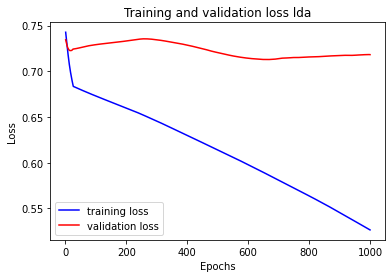

In [62]:
plt.plot(epochs, loss_history, 'b', label='training loss')
plt.plot(epochs, loss_val_history, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

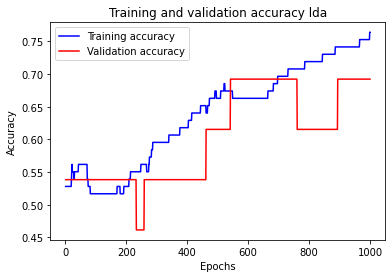

In [63]:
plt.plot(epochs, acc_history, 'b', label='Training accuracy')
plt.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [54]:
 model = build_model()
 model.fit(train_data_stand, one_hot_train_labels, epochs= 200, batch_size=89, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand, one_hot_test_labels)
  

Epoch 1/200
89/89 [==============================] - 0s 3ms/step - loss: 0.7704 - acc: 0.4944
Epoch 2/200
89/89 [==============================] - 0s 45us/step - loss: 0.7533 - acc: 0.5056
Epoch 3/200
89/89 [==============================] - 0s 25us/step - loss: 0.7378 - acc: 0.5393
Epoch 4/200
89/89 [==============================] - 0s 26us/step - loss: 0.7233 - acc: 0.5393
Epoch 5/200
89/89 [==============================] - 0s 26us/step - loss: 0.7105 - acc: 0.5169
Epoch 6/200
89/89 [==============================] - 0s 28us/step - loss: 0.6992 - acc: 0.5506
Epoch 7/200
89/89 [==============================] - 0s 27us/step - loss: 0.6894 - acc: 0.5506
Epoch 8/200
89/89 [==============================] - 0s 26us/step - loss: 0.6810 - acc: 0.5618
Epoch 9/200
89/89 [==============================] - 0s 24us/step - loss: 0.6730 - acc: 0.5843
Epoch 10/200
89/89 [==============================] - 0s 24us/step - loss: 0.6655 - acc: 0.6067
Epoch 11/200
89/89 [==============================

In [0]:
model.metrics_names

['loss', 'acc']

In [55]:
test_acc


0.6153846383094788

Si comporta molto bene in training e in validation ma si comporta male in test

#Prova con k-fold

##Vettorizzare i label

In [0]:
word_index={'large cell':0, 'squamous cell carcinoma':1}

In [0]:
train_big_labels_dec = [word_index[label] for label in y_train_big]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_big_labels = to_categorical(train_big_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

##Building Network

In [0]:
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(30, activation='relu', input_shape=(107,), kernel_regularizer=regularizers.l2(l=0.001)))
  #model.add(layers.Dropout(0.2))
  #kernel_regularizer=regularizers.l2(l=0.001)
  model.add(layers.Dense(20, activation='relu'))
  #model.add(layers.Dropout(0.1))

  model.add(layers.Dense(2, activation='sigmoid'))

  sgd = SGD(lr=0.001, momentum=0.9)
  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, min_lr=0.0001)
#usandolo la loss non scende anche se non agisce, COME MAI????
#non usandolo e non variando nient'altro la loss scende molto rapidamente

##Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [21]:
X_train_big.shape

(102, 107)

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
#skf.get_n_splits(X_train_big, one_hot_train_big_labels)

In [34]:
for train_index, test_index in skf.split(X_train_big, train_big_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   8   9  13  14  15  16  17  19  21  22  23  24
  25  26  27  28  29  32  33  34  35  36  37  38  39  40  41  43  45  46
  47  48  49  51  53  54  58  59  60  61  62  63  64  65  66  67  70  71
  72  73  74  77  78  80  82  88  89  94  95  96 100 101] TEST: [ 6  7 10 11 12 18 20 30 31 42 44 50 52 55 56 57 68 69 75 76 79 81 83 84
 85 86 87 90 91 92 93 97 98 99]
TRAIN: [  0   2   3   5   6   7   8   9  10  11  12  14  18  20  21  25  27  28
  30  31  32  34  35  37  38  42  43  44  45  48  50  51  52  55  56  57
  58  59  60  61  64  67  68  69  70  75  76  77  78  79  81  83  84  85
  86  87  88  90  91  92  93  94  95  97  98  99 100 101] TEST: [ 1  4 13 15 16 17 19 22 23 24 26 29 33 36 39 40 41 46 47 49 53 54 62 63
 65 66 71 72 73 74 80 82 89 96]
TRAIN: [ 1  4  6  7 10 11 12 13 15 16 17 18 19 20 22 23 24 26 29 30 31 33 36 39
 40 41 42 44 46 47 49 50 52 53 54 55 56 57 62 63 65 66 68 69 71 72 73 74
 75 76 79 80 81 82 83 84 85 86 87 89 90 91 92 93 96 97 98

In [35]:
train_labels_dec[125]

NameError: ignored

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_stand = scaler.fit_transform(X_train_big)
test_data_stand = scaler.transform(X_test)

In [64]:
num_epochs = 300
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []

for train_index, val_index in skf.split(train_data_stand, train_big_labels_dec):
 
  partial_train_data = np.array([train_data_stand[i] for i in train_index])
  partial_train_targets = np.array([train_big_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand[i] for i in val_index])
  val_targets = np.array([train_big_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=68, callbacks=[red_lr])
  
  acc_history = history.history['acc']
  all_acc_histories.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

ValueError: ignored

In [65]:
num_epochs = 300
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []

for train_index, val_index in skf.split(X_train_big, train_big_labels_dec):
  
  X_train_big.to_numpy() 

  partial_train_data = np.array([X_train_big[i] for i in train_index])
  partial_train_targets = np.array([train_big_labels_dec[i] for i in train_index])
  
  val_data = np.array([X_train_big[i] for i in val_index])
  val_targets = np.array([train_big_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

  #Z-score
  scaler = StandardScaler()
  partial_train_data_stand = scaler.fit_transform(partial_train_data)
  val_data_stand = scaler.transform(val_data)

  #PCA
  pca = PCA(n_components=7, svd_solver='full')
  pca.fit(partial_train_data_stand)
  partial_train_data_stand_pca = pca.transform(partial_train_data_stand)
  val_data_stand_pca = pca.transform(val_data_stand)

  #Z-score after PCA
  scaler_2 = StandardScaler()
  partial_train_data_stand_pca_stand = scaler_2.fit_transform(partial_train_data_stand_pca)
  val_data_stand_pca_stand = scaler_2.transform(val_data_stand_pca)

  model = build_model()
  history = model.fit(partial_train_data_stand_pca_stand, one_hot_partial_train_targets, validation_data=(val_data_stand_pca_stand, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=68)
  
  acc_history = history.history['acc']
  all_acc_histories.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

KeyError: ignored

In [0]:
train_index

array([  1,   2,   4,   5,   8,  10,  11,  12,  13,  14,  17,  20,  21,
        22,  23,  24,  25,  26,  27,  29,  30,  31,  33,  34,  37,  38,
        39,  40,  41,  42,  43,  46,  47,  48,  49,  50,  55,  58,  60,
        61,  62,  63,  64,  65,  67,  69,  70,  71,  73,  75,  76,  77,
        79,  81,  82,  83,  84,  85,  87,  88,  89,  91,  92,  94,  96,
        97,  98,  99, 100, 101, 103, 106, 107, 108, 110, 115, 116, 117,
       118, 119, 121, 122, 124, 126, 127, 129, 130])

In [0]:
history_dict = history.history

In [53]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

In [67]:
train_big_labels_dec

[1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1]

In [0]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]


In [41]:
len(average_val_acc_history)

300

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

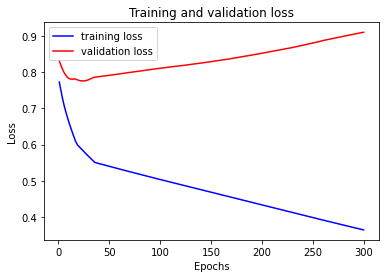

In [43]:
plt.plot(epochs, average_loss_history, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

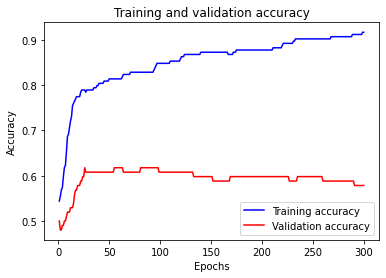

In [44]:
plt.plot(epochs, average_acc_history, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [45]:
 model = build_model()
 model.fit(train_data_stand, one_hot_train_big_labels, epochs= num_epochs, batch_size=68, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand, one_hot_test_labels)
  

Epoch 1/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8321 - acc: 0.4412
Epoch 2/300
102/102 [==============================] - 0s 56us/step - loss: 0.7646 - acc: 0.5000
Epoch 3/300
102/102 [==============================] - 0s 94us/step - loss: 0.7192 - acc: 0.5980
Epoch 4/300
102/102 [==============================] - 0s 51us/step - loss: 0.6878 - acc: 0.6569
Epoch 5/300
102/102 [==============================] - 0s 54us/step - loss: 0.6688 - acc: 0.6863
Epoch 6/300
102/102 [==============================] - 0s 54us/step - loss: 0.6488 - acc: 0.6667
Epoch 7/300
102/102 [==============================] - 0s 49us/step - loss: 0.6349 - acc: 0.7059
Epoch 8/300
102/102 [==============================] - 0s 58us/step - loss: 0.6245 - acc: 0.7255
Epoch 9/300
102/102 [==============================] - 0s 54us/step - loss: 0.6144 - acc: 0.7255
Epoch 10/300
102/102 [==============================] - 0s 67us/step - loss: 0.6054 - acc: 0.7451
Epoch 11/300
102/102 [========

In [0]:
model.metrics_names

['loss', 'acc']

In [46]:
test_acc


0.5384615659713745